# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

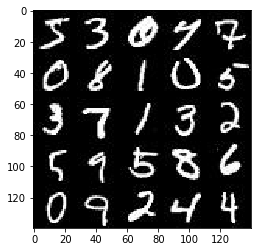

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

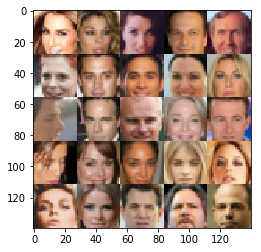

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='real_input')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [91]:
def discriminator(images, reuse=False, keep_prob=.5):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        h1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same')
        h1 = tf.maximum(alpha * h1, h1)
        h1 = tf.layers.dropout(h1, keep_prob)
        
        # 14x14x56
        h2 = tf.layers.conv2d(h1, 112, 5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha *h2, h2)
        h2 = tf.layers.dropout(h2, keep_prob)
        # 7x7x112
        
        h3 = tf.layers.conv2d(h2, 224, 5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        h3 = tf.layers.dropout(h3, keep_prob)
        # 4x4x224

        # Flatten it
        flat = tf.reshape(h3, (-1, 4*4*224))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [97]:
def generator(z, out_channel_dim, is_train=True, keep_prob=.5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=.1
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        h1 = tf.layers.dense(z, 7*7*512)
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        h1 = tf.layers.dropout(h1, keep_prob, training=is_train)
        # 7x7x512 now
        
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        h2 = tf.layers.dropout(h2, keep_prob, training=is_train)
        # 14x14x256 now
        
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        h3 = tf.layers.dropout(h3, keep_prob, training=is_train)
        # 28x28x128 now
        
        #no batch norm on last layer
        h4 = tf.layers.conv2d_transpose(h3, 64, 5, strides=1, padding='same')
        h4 = tf.maximum(alpha*h4, h4)
        
        logits = tf.layers.conv2d_transpose(h4, out_channel_dim, 5, strides=1, padding='same')
        # 28x28xout_dim now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [82]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = .1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                        labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_logits_real)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                   labels=tf.ones_like(d_logits_fake)))
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [83]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [84]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [93]:
class GAN: # image_width, image_height, image_channels, z_dim
    def __init__(self, real_size, z_dim, learning_rate, alpha=0.1, beta1=0.5):
        self.input_real, self.input_z, lr = model_inputs(real_size[1], real_size[2], real_size[3], z_dim)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[3])
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [95]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    gan = GAN(data_shape, z_dim, learning_rate, alpha=.1, beta1=beta1)
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    print_every = 20
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(gan.d_opt, feed_dict={gan.input_real: batch_images, gan.input_z: batch_z})
                _ = sess.run(gan.g_opt, feed_dict={gan.input_z: batch_z, gan.input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = gan.d_loss.eval({gan.input_z: batch_z, gan.input_real: batch_images})
                    train_loss_g = gan.g_loss.eval({gan.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 36, gan.input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6217... Generator Loss: 3.3887
Epoch 1/2... Discriminator Loss: 0.7051... Generator Loss: 1.8839
Epoch 1/2... Discriminator Loss: 0.6546... Generator Loss: 3.2915
Epoch 1/2... Discriminator Loss: 0.7675... Generator Loss: 1.6100
Epoch 1/2... Discriminator Loss: 0.8511... Generator Loss: 1.4440


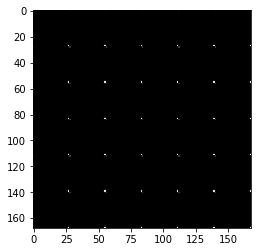

Epoch 1/2... Discriminator Loss: 1.4100... Generator Loss: 3.5185
Epoch 1/2... Discriminator Loss: 1.0174... Generator Loss: 1.0146
Epoch 1/2... Discriminator Loss: 0.8127... Generator Loss: 1.3740
Epoch 1/2... Discriminator Loss: 0.7968... Generator Loss: 1.5716
Epoch 1/2... Discriminator Loss: 0.8044... Generator Loss: 2.2889


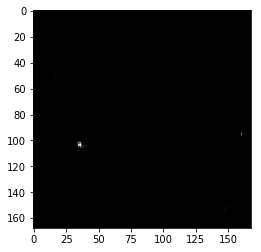

Epoch 1/2... Discriminator Loss: 0.9502... Generator Loss: 1.2451
Epoch 1/2... Discriminator Loss: 1.0706... Generator Loss: 0.8917
Epoch 1/2... Discriminator Loss: 0.7525... Generator Loss: 2.3268
Epoch 1/2... Discriminator Loss: 0.9846... Generator Loss: 1.0329
Epoch 1/2... Discriminator Loss: 0.7375... Generator Loss: 1.4479


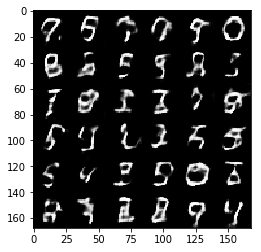

Epoch 1/2... Discriminator Loss: 0.8973... Generator Loss: 1.5483
Epoch 1/2... Discriminator Loss: 0.7434... Generator Loss: 1.6004
Epoch 1/2... Discriminator Loss: 0.7933... Generator Loss: 1.4566
Epoch 1/2... Discriminator Loss: 0.6507... Generator Loss: 1.9432
Epoch 1/2... Discriminator Loss: 1.1123... Generator Loss: 0.8572


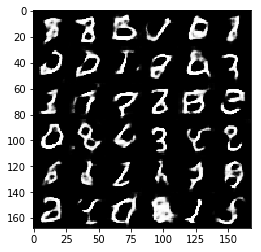

Epoch 1/2... Discriminator Loss: 0.7604... Generator Loss: 1.8605
Epoch 1/2... Discriminator Loss: 0.7246... Generator Loss: 1.3959
Epoch 1/2... Discriminator Loss: 0.7492... Generator Loss: 1.6492
Epoch 1/2... Discriminator Loss: 0.8862... Generator Loss: 1.3342
Epoch 1/2... Discriminator Loss: 0.7728... Generator Loss: 1.9591


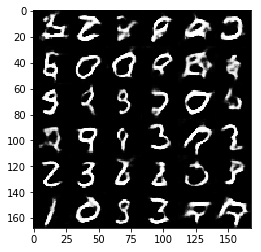

Epoch 1/2... Discriminator Loss: 0.8035... Generator Loss: 1.6872
Epoch 1/2... Discriminator Loss: 0.7709... Generator Loss: 1.5171
Epoch 1/2... Discriminator Loss: 0.9997... Generator Loss: 0.8948
Epoch 1/2... Discriminator Loss: 0.7999... Generator Loss: 1.3162
Epoch 1/2... Discriminator Loss: 0.7808... Generator Loss: 2.0926


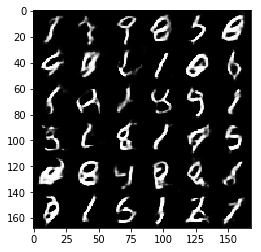

Epoch 1/2... Discriminator Loss: 0.7359... Generator Loss: 1.8807
Epoch 1/2... Discriminator Loss: 0.8501... Generator Loss: 1.5015
Epoch 1/2... Discriminator Loss: 0.7982... Generator Loss: 1.6505
Epoch 1/2... Discriminator Loss: 0.9543... Generator Loss: 1.3216
Epoch 1/2... Discriminator Loss: 0.8189... Generator Loss: 1.7172


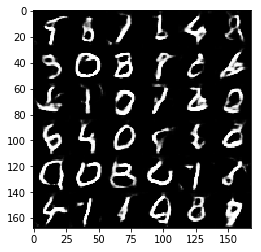

Epoch 1/2... Discriminator Loss: 0.7826... Generator Loss: 1.5701
Epoch 1/2... Discriminator Loss: 0.7103... Generator Loss: 1.8822
Epoch 1/2... Discriminator Loss: 0.7733... Generator Loss: 2.2557
Epoch 1/2... Discriminator Loss: 0.9260... Generator Loss: 1.2373
Epoch 1/2... Discriminator Loss: 0.8120... Generator Loss: 1.4089


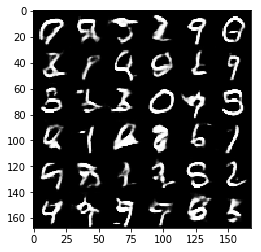

Epoch 1/2... Discriminator Loss: 0.7344... Generator Loss: 1.5162
Epoch 1/2... Discriminator Loss: 0.5824... Generator Loss: 2.2159
Epoch 1/2... Discriminator Loss: 0.8215... Generator Loss: 1.7993
Epoch 1/2... Discriminator Loss: 0.6403... Generator Loss: 1.6900
Epoch 1/2... Discriminator Loss: 0.7271... Generator Loss: 1.6097


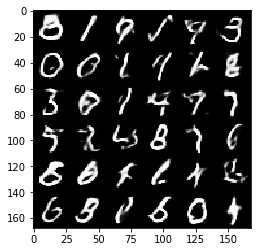

Epoch 1/2... Discriminator Loss: 0.7714... Generator Loss: 1.5819
Epoch 2/2... Discriminator Loss: 0.6983... Generator Loss: 1.6554
Epoch 2/2... Discriminator Loss: 0.6886... Generator Loss: 1.8450
Epoch 2/2... Discriminator Loss: 0.6813... Generator Loss: 2.1222
Epoch 2/2... Discriminator Loss: 0.7518... Generator Loss: 1.5204


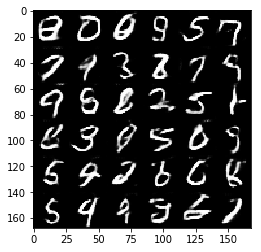

Epoch 2/2... Discriminator Loss: 0.7357... Generator Loss: 1.6895
Epoch 2/2... Discriminator Loss: 0.7796... Generator Loss: 1.6090
Epoch 2/2... Discriminator Loss: 0.6797... Generator Loss: 1.9213
Epoch 2/2... Discriminator Loss: 0.8862... Generator Loss: 1.2957
Epoch 2/2... Discriminator Loss: 0.7197... Generator Loss: 1.8098


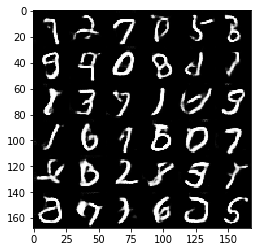

Epoch 2/2... Discriminator Loss: 0.5939... Generator Loss: 2.1972
Epoch 2/2... Discriminator Loss: 0.6925... Generator Loss: 1.7826
Epoch 2/2... Discriminator Loss: 0.6309... Generator Loss: 1.7331
Epoch 2/2... Discriminator Loss: 0.8074... Generator Loss: 1.3541
Epoch 2/2... Discriminator Loss: 0.7290... Generator Loss: 2.4179


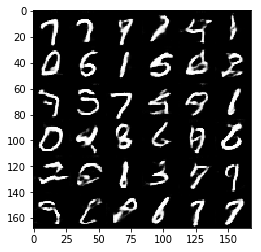

Epoch 2/2... Discriminator Loss: 0.7780... Generator Loss: 2.1783
Epoch 2/2... Discriminator Loss: 0.8249... Generator Loss: 1.3933
Epoch 2/2... Discriminator Loss: 0.6914... Generator Loss: 1.9465
Epoch 2/2... Discriminator Loss: 1.1456... Generator Loss: 0.9633
Epoch 2/2... Discriminator Loss: 0.7825... Generator Loss: 2.7532


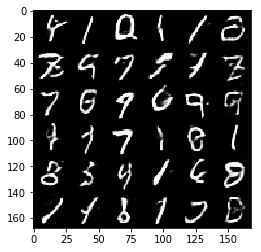

Epoch 2/2... Discriminator Loss: 1.5909... Generator Loss: 2.6432
Epoch 2/2... Discriminator Loss: 0.7134... Generator Loss: 1.7121
Epoch 2/2... Discriminator Loss: 0.7339... Generator Loss: 2.1490
Epoch 2/2... Discriminator Loss: 0.6080... Generator Loss: 1.8713
Epoch 2/2... Discriminator Loss: 0.8036... Generator Loss: 2.8121


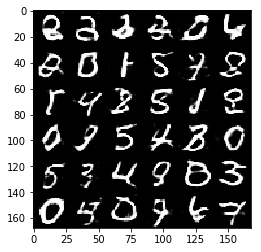

Epoch 2/2... Discriminator Loss: 0.6906... Generator Loss: 1.6889
Epoch 2/2... Discriminator Loss: 0.5625... Generator Loss: 2.2726
Epoch 2/2... Discriminator Loss: 0.6980... Generator Loss: 2.2009
Epoch 2/2... Discriminator Loss: 0.8033... Generator Loss: 1.3813
Epoch 2/2... Discriminator Loss: 0.7108... Generator Loss: 1.7845


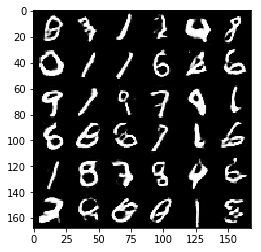

Epoch 2/2... Discriminator Loss: 0.7146... Generator Loss: 1.6565
Epoch 2/2... Discriminator Loss: 0.7973... Generator Loss: 1.2845
Epoch 2/2... Discriminator Loss: 0.8806... Generator Loss: 2.7194
Epoch 2/2... Discriminator Loss: 0.6755... Generator Loss: 2.1063
Epoch 2/2... Discriminator Loss: 0.7342... Generator Loss: 2.2084


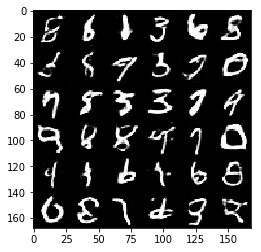

Epoch 2/2... Discriminator Loss: 0.6650... Generator Loss: 1.7680
Epoch 2/2... Discriminator Loss: 0.6094... Generator Loss: 1.9274
Epoch 2/2... Discriminator Loss: 0.5495... Generator Loss: 2.1983
Epoch 2/2... Discriminator Loss: 0.6776... Generator Loss: 2.7173
Epoch 2/2... Discriminator Loss: 0.7330... Generator Loss: 1.3225


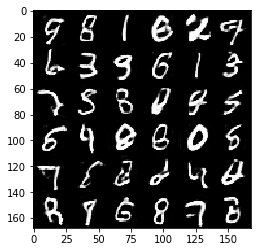

Epoch 2/2... Discriminator Loss: 0.9390... Generator Loss: 1.2888
Epoch 2/2... Discriminator Loss: 0.6360... Generator Loss: 1.8336
Epoch 2/2... Discriminator Loss: 0.6687... Generator Loss: 2.1269
Epoch 2/2... Discriminator Loss: 0.5378... Generator Loss: 2.4474
Epoch 2/2... Discriminator Loss: 1.1044... Generator Loss: 0.9674


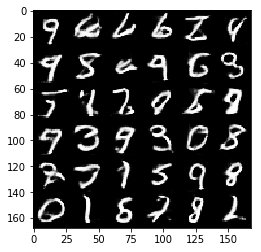

Epoch 2/2... Discriminator Loss: 0.9318... Generator Loss: 1.2536
Epoch 2/2... Discriminator Loss: 0.6743... Generator Loss: 1.5336
Epoch 2/2... Discriminator Loss: 0.6891... Generator Loss: 1.8204


In [98]:
batch_size = 64
z_dim = 100
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3973... Generator Loss: 3.5007
Epoch 1/1... Discriminator Loss: 0.3734... Generator Loss: 3.6486
Epoch 1/1... Discriminator Loss: 0.4485... Generator Loss: 4.1841
Epoch 1/1... Discriminator Loss: 0.6056... Generator Loss: 2.3629
Epoch 1/1... Discriminator Loss: 0.5875... Generator Loss: 1.9701


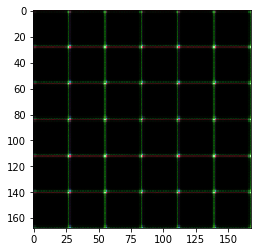

Epoch 1/1... Discriminator Loss: 0.4134... Generator Loss: 3.1072
Epoch 1/1... Discriminator Loss: 0.5560... Generator Loss: 2.0342
Epoch 1/1... Discriminator Loss: 0.6284... Generator Loss: 2.8042
Epoch 1/1... Discriminator Loss: 0.7732... Generator Loss: 1.9043
Epoch 1/1... Discriminator Loss: 0.6327... Generator Loss: 2.9099


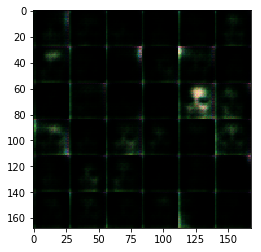

Epoch 1/1... Discriminator Loss: 0.6145... Generator Loss: 1.9866
Epoch 1/1... Discriminator Loss: 0.6615... Generator Loss: 1.8771
Epoch 1/1... Discriminator Loss: 0.6124... Generator Loss: 2.0911
Epoch 1/1... Discriminator Loss: 0.5309... Generator Loss: 2.4849
Epoch 1/1... Discriminator Loss: 0.6159... Generator Loss: 2.4500


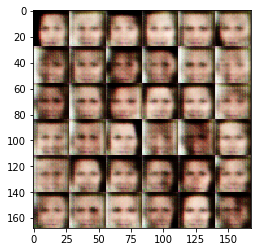

Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 3.2850
Epoch 1/1... Discriminator Loss: 0.7781... Generator Loss: 1.3867
Epoch 1/1... Discriminator Loss: 0.7249... Generator Loss: 1.6932
Epoch 1/1... Discriminator Loss: 0.5526... Generator Loss: 2.2246
Epoch 1/1... Discriminator Loss: 0.7082... Generator Loss: 1.7196


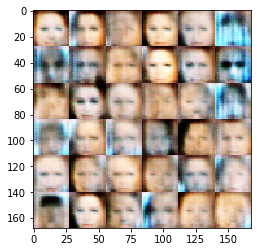

Epoch 1/1... Discriminator Loss: 0.5888... Generator Loss: 2.2069
Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 2.4449
Epoch 1/1... Discriminator Loss: 0.6663... Generator Loss: 1.7921
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 4.0957
Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 1.8112


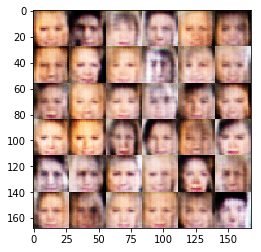

Epoch 1/1... Discriminator Loss: 0.6883... Generator Loss: 1.8862
Epoch 1/1... Discriminator Loss: 0.7227... Generator Loss: 1.6213
Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 2.4269
Epoch 1/1... Discriminator Loss: 0.6478... Generator Loss: 2.0690
Epoch 1/1... Discriminator Loss: 0.7810... Generator Loss: 1.4887


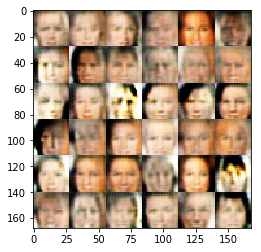

Epoch 1/1... Discriminator Loss: 0.6716... Generator Loss: 1.7927
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 1.2210
Epoch 1/1... Discriminator Loss: 0.7210... Generator Loss: 1.7391
Epoch 1/1... Discriminator Loss: 0.6680... Generator Loss: 2.0351


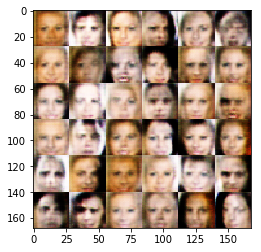

Epoch 1/1... Discriminator Loss: 0.7317... Generator Loss: 2.5143
Epoch 1/1... Discriminator Loss: 0.6782... Generator Loss: 1.6095
Epoch 1/1... Discriminator Loss: 0.6796... Generator Loss: 1.5432
Epoch 1/1... Discriminator Loss: 0.6549... Generator Loss: 2.0180
Epoch 1/1... Discriminator Loss: 0.9040... Generator Loss: 2.9036


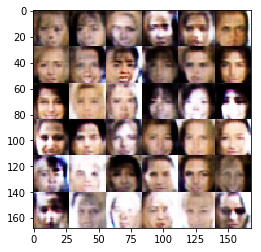

Epoch 1/1... Discriminator Loss: 0.8633... Generator Loss: 1.2432
Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 1.3982
Epoch 1/1... Discriminator Loss: 0.6899... Generator Loss: 2.4009
Epoch 1/1... Discriminator Loss: 0.8100... Generator Loss: 1.8928
Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 1.0292


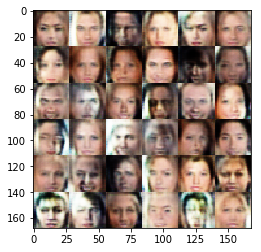

Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 0.7890... Generator Loss: 1.1721
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.3106
Epoch 1/1... Discriminator Loss: 0.7574... Generator Loss: 1.5374


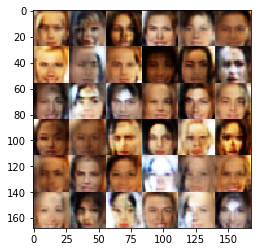

Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 2.1800
Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 1.8195
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 1.1358
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 1.0775
Epoch 1/1... Discriminator Loss: 0.8528... Generator Loss: 2.0298


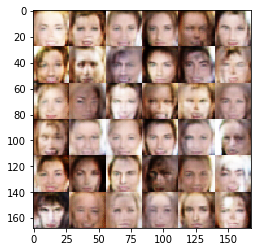

Epoch 1/1... Discriminator Loss: 0.8267... Generator Loss: 2.2949
Epoch 1/1... Discriminator Loss: 0.8370... Generator Loss: 1.2719
Epoch 1/1... Discriminator Loss: 0.7027... Generator Loss: 1.7458
Epoch 1/1... Discriminator Loss: 0.7761... Generator Loss: 1.8263
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 0.8895


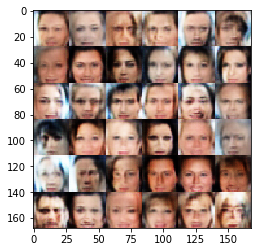

Epoch 1/1... Discriminator Loss: 0.7992... Generator Loss: 1.7550
Epoch 1/1... Discriminator Loss: 0.7958... Generator Loss: 2.1006
Epoch 1/1... Discriminator Loss: 0.7941... Generator Loss: 1.5564
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 0.8503... Generator Loss: 1.6385


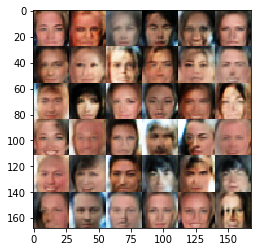

Epoch 1/1... Discriminator Loss: 0.8008... Generator Loss: 1.2503
Epoch 1/1... Discriminator Loss: 0.8091... Generator Loss: 1.4197
Epoch 1/1... Discriminator Loss: 0.7194... Generator Loss: 1.9739
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 1.1356
Epoch 1/1... Discriminator Loss: 0.9183... Generator Loss: 1.2628


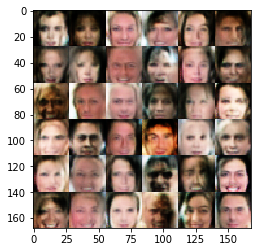

Epoch 1/1... Discriminator Loss: 0.9441... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 0.8718... Generator Loss: 1.4447
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 1.5493
Epoch 1/1... Discriminator Loss: 0.7515... Generator Loss: 1.4840
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 1.1614


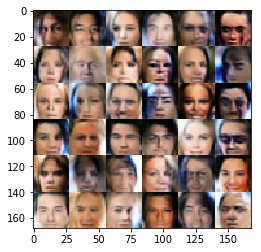

Epoch 1/1... Discriminator Loss: 0.7968... Generator Loss: 1.8481
Epoch 1/1... Discriminator Loss: 0.7912... Generator Loss: 2.0232
Epoch 1/1... Discriminator Loss: 0.8138... Generator Loss: 1.3429
Epoch 1/1... Discriminator Loss: 0.7034... Generator Loss: 1.5556
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 0.9783


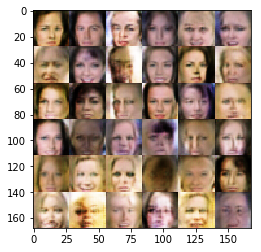

Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 1.0378
Epoch 1/1... Discriminator Loss: 0.7546... Generator Loss: 1.4691
Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 1.1937
Epoch 1/1... Discriminator Loss: 0.7636... Generator Loss: 1.7239


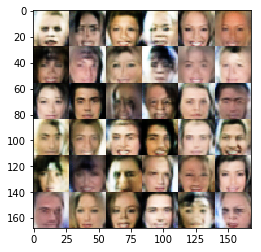

Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 1.5266
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 1.5938
Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 1.1384
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 1.0118
Epoch 1/1... Discriminator Loss: 0.7972... Generator Loss: 1.6927


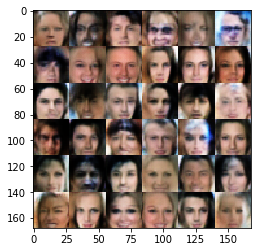

Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 1.4110
Epoch 1/1... Discriminator Loss: 0.6621... Generator Loss: 2.2641
Epoch 1/1... Discriminator Loss: 0.6501... Generator Loss: 1.9083
Epoch 1/1... Discriminator Loss: 0.7157... Generator Loss: 2.2215
Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 1.7783


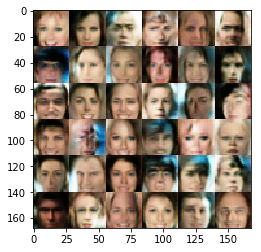

Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 1.6314
Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 1.5168
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 0.7744... Generator Loss: 2.2443


In [99]:
batch_size = 32
z_dim = 100
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.